<a href="https://colab.research.google.com/github/YAMINISARASWATHI04/DL-Assignment/blob/main/momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andhikawb/fashion-mnist-png")

print("Path to dataset files:", path)

100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1"  # Update with actual path
train_path = os.path.join(dataset_path, "train")


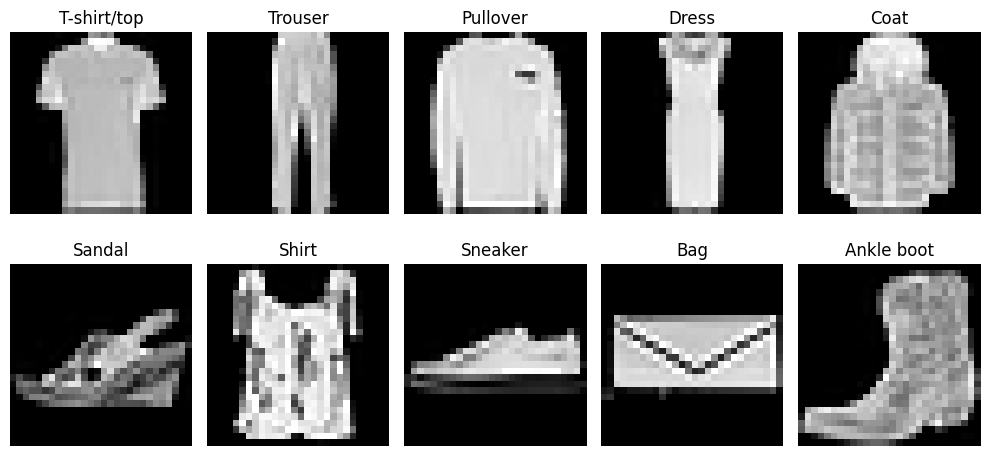

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, label in enumerate(class_labels):
    class_dir = os.path.join(train_path, str(i))
    sample_image = os.listdir(class_dir)[0]
    image_path = os.path.join(class_dir, sample_image)

    img = Image.open(image_path).convert("L")  # Open and convert to grayscale

    ax = axes[i // 5, i % 5]  # Subplot positioning
    ax.imshow(img, cmap="gray")
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [ ]:
# Define transformations (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Split training dataset (90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define class labels
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 1.12MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
batch_size=32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class FlexibleFNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers=[128, 64], activation="relu", weight_init="xavier"):
        super(FlexibleFNN, self).__init__()

        layers = []
        prev_size = input_size

        # Activation function selection
        if activation == "relu":
            activation_fn = nn.ReLU()
        elif activation == "sigmoid":
            activation_fn = nn.Sigmoid()
        else:
            raise ValueError("Invalid activation function. Choose 'relu' or 'sigmoid'.")

        # Create hidden layers
        for hidden_size in hidden_layers:
            layer = nn.Linear(prev_size, hidden_size)

            # Apply weight initialization
            if weight_init == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif weight_init == "random":
                nn.init.uniform_(layer.weight, -0.1, 0.1)
            else:
                raise ValueError("Invalid weight initialization. Choose 'xavier' or 'random'.")

            layers.append(layer)
            layers.append(activation_fn)
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 10))  # 10 classes

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)


In [ ]:
def get_optimizer(optimizer_name, model_params, learning_rate, weight_decay):
    if optimizer_name == "sgd":
        return optim.SGD(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "momentum":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "nesterov":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif optimizer_name == "rmsprop":
        return optim.RMSprop(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "adam":
        return optim.Adam(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "nadam":
        return optim.NAdam(model_params, lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Invalid optimizer choice.")


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, config_name, num_epochs=10):
    """Train the model and store validation accuracy for each epoch."""
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_accuracies = []  # Store validation accuracy for each epoch
    train_losses = []  # Store training losses for each epoch
    val_losses = []  # Store validation losses for each epoch

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        train_losses.append(total_loss / len(train_loader))

        # Compute Validation Accuracy
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0
        for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Calculate validation loss
                val_loss += loss.item()  # Accumulate validation loss

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_accuracies.append(val_acc)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%, Val Accuracy: {val_acc:.2f}%")

    # Store results for analysis
    experiment_results[config_name] = {
        "val_accuracies": val_accuracies,
        "train_losses": train_losses,  # Store training losses
        "val_losses": val_losses,  # Store validation losses
        "model": model
    }

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
experiment_results = {}  # Dictionary to store results

# Define different configurations
configs = [
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64], "activation": "relu", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [64, 32], "activation": "sigmoid", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64], "activation": "sigmoid", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64, 32], "activation": "sigmoid", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},

]

# Train models with different configurations
for config in configs:
    print(f"\nTraining with config: {config}\n")

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = FlexibleFNN(hidden_layers=config["hidden_layers"], activation=config["activation"], weight_init=config["init"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"], weight_decay=0.0005)

    # Access the loss_function key, which is now present
    if config["loss_function"] == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif config["loss_function"] == "mse":
        criterion = nn.MSELoss()
    else:
        raise ValueError("Invalid loss function choice.")

    train_model(model, train_loader, val_loader, optimizer, str(config), num_epochs=10)


Training with config: {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}

Epoch [1/10], Loss: 0.7363, Train Accuracy: 74.08%, Val Accuracy: 81.57%
Epoch [2/10], Loss: 0.4746, Train Accuracy: 82.96%, Val Accuracy: 83.97%
Epoch [3/10], Loss: 0.4295, Train Accuracy: 84.46%, Val Accuracy: 84.97%
Epoch [4/10], Loss: 0.4043, Train Accuracy: 85.54%, Val Accuracy: 85.42%
Epoch [5/10], Loss: 0.3835, Train Accuracy: 86.26%, Val Accuracy: 85.42%
Epoch [6/10], Loss: 0.3704, Train Accuracy: 86.77%, Val Accuracy: 86.53%
Epoch [7/10], Loss: 0.3574, Train Accuracy: 87.19%, Val Accuracy: 86.75%
Epoch [8/10], Loss: 0.3465, Train Accuracy: 87.58%, Val Accuracy: 86.55%
Epoch [9/10], Loss: 0.3383, Train Accuracy: 87.80%, Val Accuracy: 87.25%
Epoch [10/10], Loss: 0.3291, Train Accuracy: 88.11%, Val Accuracy: 87.30%

Training with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 

In [ ]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

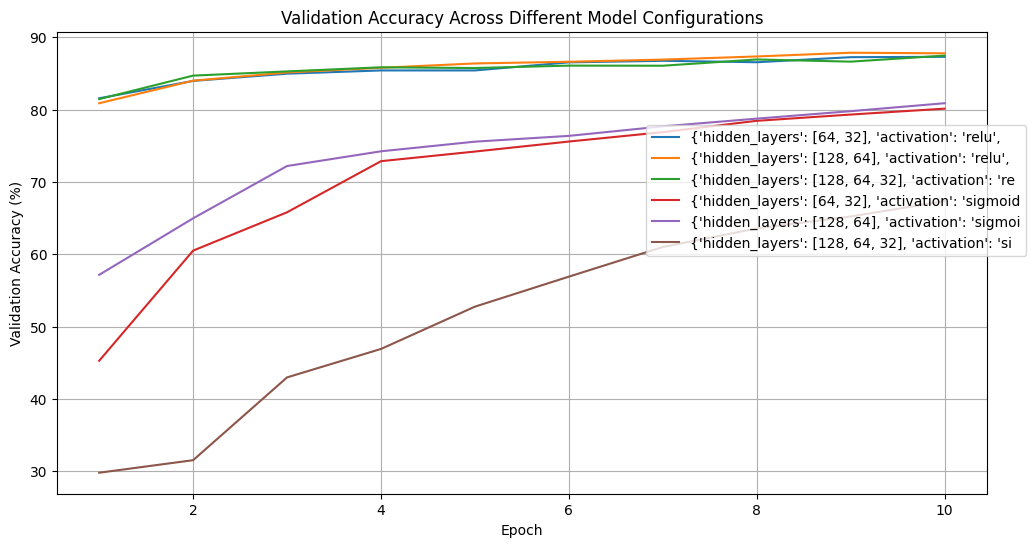

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracy for each experiment
plt.figure(figsize=(12, 6))

for config_name, results in experiment_results.items():  # Access the dictionary with results
    val_acc = results['val_accuracies']  # Access the 'val_accuracies' list
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=config_name[:50])  # Shortened config name

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Different Model Configurations")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5))
plt.grid()
plt.show()

In [ ]:
import torch

def compute_test_accuracy(model, test_loader, device):

    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    test_accuracy = (correct_predictions / total_samples) * 100
    return test_accuracy


In [ ]:
# Dictionary to store test accuracies for each model configuration
test_accuracies = {}

for config_name, model_data in experiment_results.items():
    model = model_data['model']  # Retrieve the trained model
    accuracy = compute_test_accuracy(model, test_loader, device)
    test_accuracies[config_name] = accuracy
    print(f"Test Accuracy for {config_name}: {accuracy:.2f}%")


Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 86.42%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 86.57%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 86.49%
Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'sigmoid', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 79.24%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'sigmoid', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 79.46%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 's

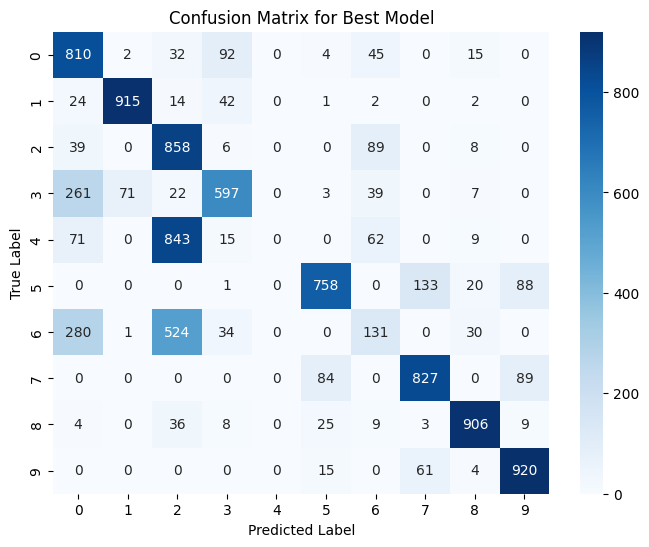

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
experiment_results = {}  # Dictionary to store results

# Define different configurations
configs = [
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64], "activation": "relu", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [64, 32], "activation": "sigmoid", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64], "activation": "sigmoid", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64, 32], "activation": "sigmoid", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},

]

# Train models with different configurations
for config in configs:
    print(f"\nTraining with config: {config}\n")

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = FlexibleFNN(hidden_layers=config["hidden_layers"], activation=config["activation"], weight_init=config["init"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"], weight_decay=0.0005)

    # Access the loss_function key, which is now present
    if config["loss_function"] == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif config["loss_function"] == "mse":
        criterion = nn.MSELoss()
    else:
        raise ValueError("Invalid loss function choice.")

    train_model(model, train_loader, val_loader, optimizer, str(config), num_epochs=10)


Training with config: {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}

Epoch [1/10], Loss: 0.7441, Train Accuracy: 74.26%, Val Accuracy: 81.48%
Epoch [2/10], Loss: 0.4763, Train Accuracy: 82.89%, Val Accuracy: 83.22%
Epoch [3/10], Loss: 0.4296, Train Accuracy: 84.53%, Val Accuracy: 84.83%
Epoch [4/10], Loss: 0.4020, Train Accuracy: 85.59%, Val Accuracy: 85.50%
Epoch [5/10], Loss: 0.3839, Train Accuracy: 86.18%, Val Accuracy: 85.87%
Epoch [6/10], Loss: 0.3699, Train Accuracy: 86.73%, Val Accuracy: 86.08%
Epoch [7/10], Loss: 0.3574, Train Accuracy: 87.18%, Val Accuracy: 86.52%
Epoch [8/10], Loss: 0.3468, Train Accuracy: 87.47%, Val Accuracy: 86.72%
Epoch [9/10], Loss: 0.3376, Train Accuracy: 87.78%, Val Accuracy: 86.82%
Epoch [10/10], Loss: 0.3303, Train Accuracy: 88.10%, Val Accuracy: 86.58%

Training with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'momentum'

In [ ]:
test_accuracies = {}

for config_name, model_data in experiment_results.items():
    model = model_data['model']  # Retrieve the trained model
    accuracy = compute_test_accuracy(model, test_loader, device)
    test_accuracies[config_name] = accuracy
    print(f"Test Accuracy for {config_name}: {accuracy:.2f}%")

Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.08%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.59%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.77%
Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'sigmoid', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 77.75%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'sigmoid', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 79.74%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'sigmoid', 'optimizer': 'momentum', 'batch_size': 32

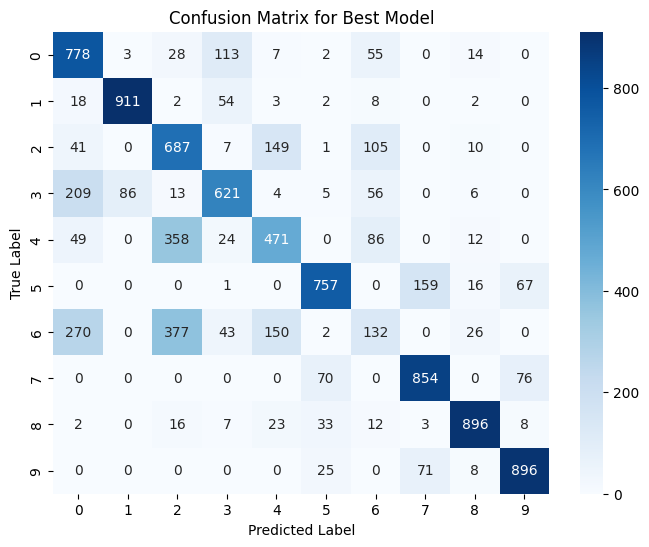

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


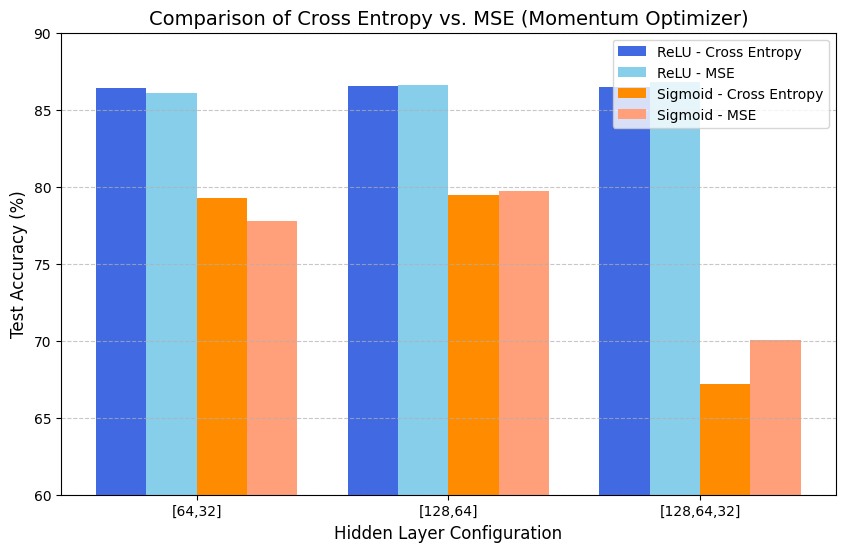

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the test results
hidden_layer_configs = ['[64,32]', '[128,64]', '[128,64,32]']

relu_cross_entropy = [86.42, 86.57, 86.49]
relu_mse = [86.08, 86.59, 86.77]

sigmoid_cross_entropy = [79.24, 79.46, 67.22]
sigmoid_mse = [77.75, 79.74, 70.03]

# Set bar width
bar_width = 0.2
index = np.arange(len(hidden_layer_configs))

# Plot bars
plt.figure(figsize=(10, 6))

plt.bar(index - bar_width, relu_cross_entropy, bar_width, label="ReLU - Cross Entropy", color='royalblue')
plt.bar(index, relu_mse, bar_width, label="ReLU - MSE", color='skyblue')

plt.bar(index + bar_width, sigmoid_cross_entropy, bar_width, label="Sigmoid - Cross Entropy", color='darkorange')
plt.bar(index + 2*bar_width, sigmoid_mse, bar_width, label="Sigmoid - MSE", color='lightsalmon')

# Labels and titles
plt.xlabel("Hidden Layer Configuration", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.title("Comparison of Cross Entropy vs. MSE (Momentum Optimizer)", fontsize=14)
plt.xticks(index + bar_width / 2, hidden_layer_configs)  # Align x-axis labels
plt.ylim(60, 90)  # Set y-axis limits for better visualization
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [1]:
print("\n=== Inferences from the Comparison of Cross Entropy and MSE (Momentum Optimizer) ===\n")

print("1️⃣ ReLU activation consistently outperforms Sigmoid across all configurations,")
print("   confirming its superiority in deep learning tasks.\n")

print("2️⃣ Cross Entropy vs. MSE for ReLU:")
print("   - The performance of both loss functions is very close.")
print("   - MSE slightly outperforms Cross Entropy in some cases (e.g., [128, 64, 32]: 86.77% vs. 86.49%).")
print("   - However, the difference is marginal, making both viable choices when using ReLU.\n")

print("3️⃣ Cross Entropy vs. MSE for Sigmoid:")
print("   - The performance of Sigmoid remains significantly lower than ReLU.")
print("   - MSE leads to slightly better results than Cross Entropy in deeper networks ([128, 64, 32]: 70.03% vs. 67.22%).")
print("   - However, both loss functions struggle with Sigmoid, reinforcing that activation choice is more critical than loss function choice.\n")

print("4️⃣ Momentum optimizer yields stable results, with ReLU performing around 86.5% accuracy.")
print("   - Sigmoid remains a suboptimal choice, never exceeding ~80% accuracy.\n")

print("💡 Final Takeaway:")
print("   - ✅ ReLU remains the best activation function regardless of loss function choice.")
print("   - 🔹 MSE and Cross Entropy perform similarly when using ReLU.")
print("   - 🚫 Sigmoid activation is not suitable for this task, as it consistently underperforms.\n")



=== Inferences from the Comparison of Cross Entropy and MSE (Momentum Optimizer) ===

1️⃣ ReLU activation consistently outperforms Sigmoid across all configurations,
   confirming its superiority in deep learning tasks.

2️⃣ Cross Entropy vs. MSE for ReLU:
   - The performance of both loss functions is very close.
   - MSE slightly outperforms Cross Entropy in some cases (e.g., [128, 64, 32]: 86.77% vs. 86.49%).
   - However, the difference is marginal, making both viable choices when using ReLU.

3️⃣ Cross Entropy vs. MSE for Sigmoid:
   - The performance of Sigmoid remains significantly lower than ReLU.
   - MSE leads to slightly better results than Cross Entropy in deeper networks ([128, 64, 32]: 70.03% vs. 67.22%).
   - However, both loss functions struggle with Sigmoid, reinforcing that activation choice is more critical than loss function choice.

4️⃣ Momentum optimizer yields stable results, with ReLU performing around 86.5% accuracy.
   - Sigmoid remains a suboptimal choice, n